In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
%matplotlib inline
import pandas as pd
import numpy as np
from keras.utils import np_utils
from PIL import Image
from tqdm import tqdm
import os
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dropout, Flatten, Dense, LeakyReLU, Input, BatchNormalization, Activation, Conv2DTranspose
from keras.optimizers import Adam
from keras.utils import plot_model
import random
from numpy.random import rand

In [2]:

image_width= 256
image_height=256

directory= 'video/'
videolist=os.listdir(directory)
dim = (256, 256)

for i in range(len(videolist)):
    c=0
    videofile= videolist[i]
    print(videofile)

    
    cap= cv2.VideoCapture(directory+videofile)
    framerate=cap.get(5)
    x=1
    while(cap.isOpened()):
        frameid=cap.get(60)
        ret,frame=cap.read()
        if ret!=True:
            break
        if (frameid % math.floor(framerate)==0):
            resized= cv2.resize(frame,dim,interpolation = cv2.INTER_AREA)
            filename="newimage2/" + videofile[i] +"_frame%d.jpg" % c
            c+=1
            cv2.imwrite(filename, resized)
    cap.release()


'\nimage_width= 256\nimage_height=256\n\ndirectory= \'video/\'\nvideolist=os.listdir(directory)\ndim = (256, 256)\n\nfor i in range(len(videolist)):\n    c=0\n    videofile= videolist[i]\n    print(videofile)\n\n    \n    cap= cv2.VideoCapture(directory+videofile)\n    framerate=cap.get(5)\n    x=1\n    while(cap.isOpened()):\n        frameid=cap.get(60)\n        #print(frameid)\n        ret,frame=cap.read()\n        if ret!=True:\n            break\n        if (frameid % math.floor(framerate)==0):\n            resized= cv2.resize(frame,dim,interpolation = cv2.INTER_AREA)\n            filename="newimage2/" + videofile[i] +"_frame%d.jpg" % c\n            c+=1\n            cv2.imwrite(filename, resized)\n    cap.release()\n'

In [3]:

trainimage=os.listdir('newimage')
x= pd.DataFrame(trainimage, columns=['name'])
#y= np.ones((len(trainimage),1))
y= ['1']* x.shape[0]
x['target']=y


"\ntrainimage=os.listdir('newimage')\nx= pd.DataFrame(trainimage, columns=['name'])\n#y= np.ones((len(trainimage),1))\ny= ['1']* x.shape[0]\nx['target']=y\n"

In [4]:
INPUT_DIR= "newimage/"
batch= 64
noise_shape= (1,1,100)
image_shape=(64,64,3)
steps = 10000

In [6]:
def generator(noise_shape):
    noise_shape = noise_shape
    kernel_init = 'glorot_uniform'
    inpu = Input(shape = noise_shape)
    x = Conv2DTranspose(filters = 1024, kernel_size = (4,4), strides = (1,1), padding = "valid", data_format = "channels_last", kernel_initializer = kernel_init)(inpu)
    x = BatchNormalization(momentum = 0.5)(x)
    x = LeakyReLU(0.2)(x)
        
    x = Conv2DTranspose(filters = 512, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters = 256, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters = 64, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters = 3, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(x)
    x = Activation('tanh')(x)
        
    adamoptimizer = Adam(lr=0.00015, beta_1=0.5)
    model = Model(inputs = inpu, outputs = x)
    model.compile(loss='binary_crossentropy', optimizer=adamoptimizer, metrics=['accuracy'])

    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1, 100)]       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 1024)        1639424   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 1024)        4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 512)         8389120   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 512)         0     

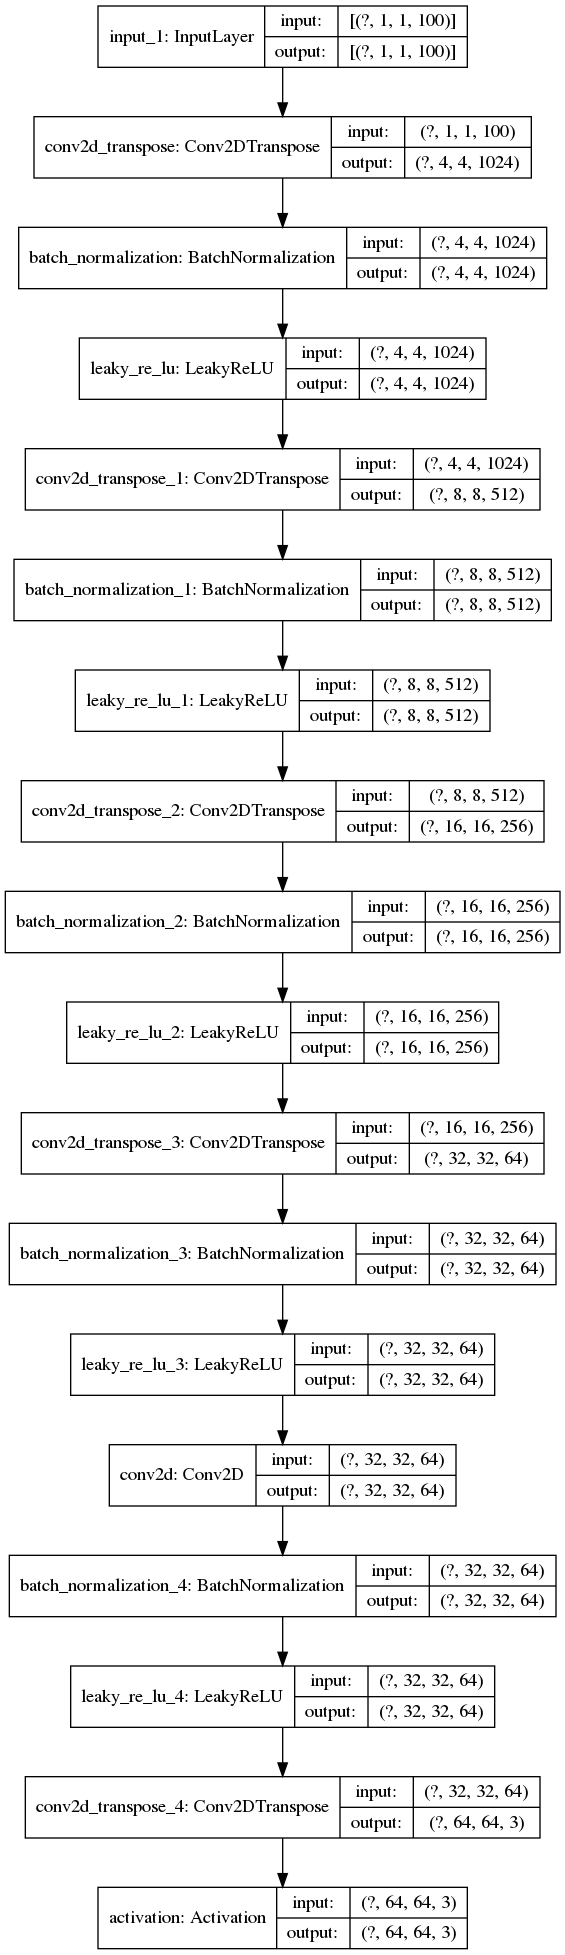

In [7]:
g= generator(noise_shape)
g.summary()
plot_model(g, to_file='generator_plot.png', show_shapes=True)

In [8]:
def discriminator(image_shape=(64,64,3)):
    image_shape = image_shape
    
    dropout_prob = 0.4
    kernel_init = 'glorot_uniform'
    inpu = Input(shape = image_shape)
    x = Conv2D(filters = 64, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(inpu)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters = 128, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = LeakyReLU(0.2)(x)
   
    x = Conv2D(filters = 256, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters = 512, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Flatten()(x)
    
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    #also try the SGD optimiser, might work better for a few learning rates.
    dis_opt = Adam(lr=0.0002, beta_1=0.5)
    model = Model(inputs = inpu, outputs = x)
    model.compile(loss='binary_crossentropy', optimizer=dis_opt, metrics=['accuracy'])

    return model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         5245

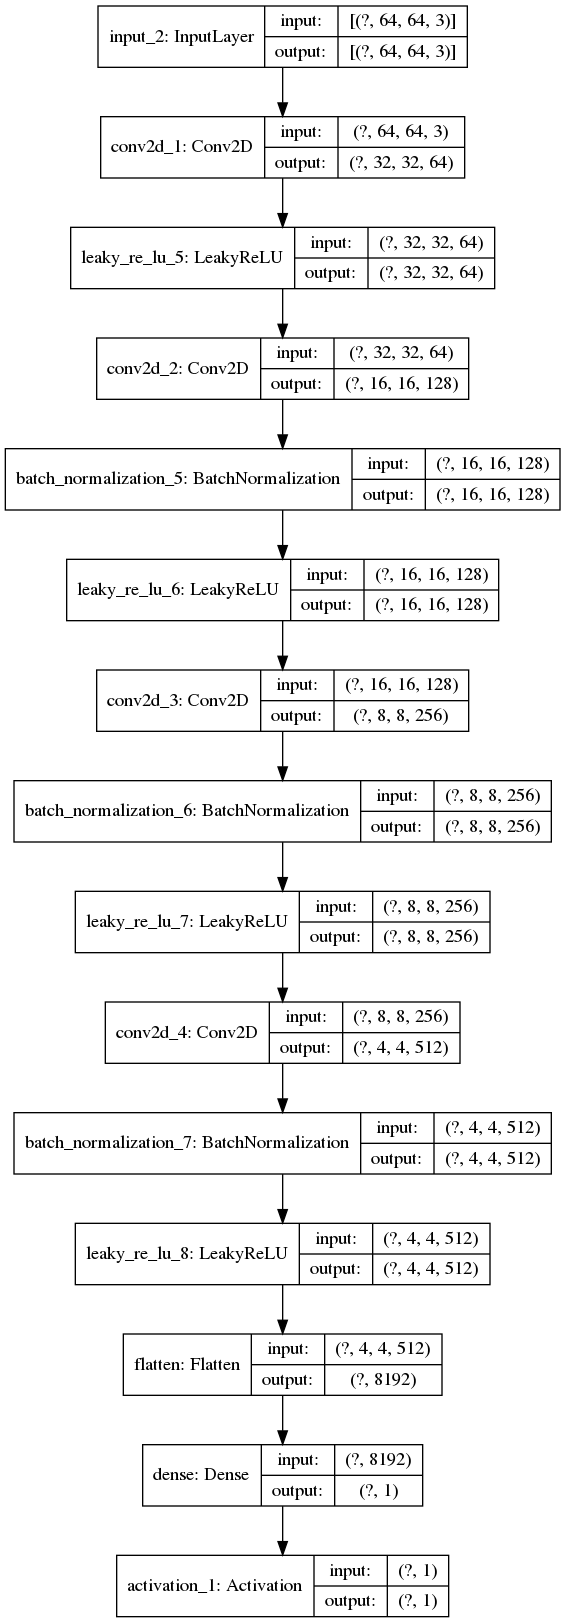

In [9]:
d= discriminator()
d.summary()
plot_model(d, to_file='discriminator_plot.png', show_shapes=True)

In [10]:
def create_gan(d, g):
    d.trainable=False
    gan_input= Input(shape=noise_shape)
    x= g(gan_input)
    gan_output=d(x)
    gan= Model(inputs= gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    return gan

In [11]:
gan= create_gan(d, g)
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 1, 100)]       0         
_________________________________________________________________
model (Model)                (None, 64, 64, 3)         12435843  
_________________________________________________________________
model_1 (Model)              (None, 1)                 2768321   
Total params: 15,204,164
Trainable params: 12,432,003
Non-trainable params: 2,772,161
_________________________________________________________________


In [12]:
def norm_img(img):
    img = (img / 127.5) - 1
    #image normalisation to keep values between -1 and 1 for stability
    return img

In [13]:
def denorm_img(img):
    #for output
    img = (img + 1) * 127.5
    return img.astype(np.uint8) 

In [14]:
def gen_noise(batch, noise_shape):
    #Generation of random noise
    return np.random.normal(0, 1, size=(batch,)+(noise_shape))

In [15]:
data_dir=[]
current_dir =  '/home/rathore-adityasingh/HOME ASR/App Ast/GAN/GAN2/newimage/'
filenames=os.listdir(current_dir)
for i in filenames:
    fullpath= current_dir+i
    data_dir.append(fullpath)

In [16]:
def sample_from_dataset(batch, image_shape, data_dir=None, data = None):
    sample_dim = (batch,) + image_shape
    sample = np.empty(sample_dim, dtype=np.float32)  
    sample_imgs_paths = np.random.choice(data_dir,batch)
    for index,img_filename in enumerate(sample_imgs_paths):
        image = Image.open(img_filename)
        image = image.resize(image_shape[:-1])
        image = image.convert('RGB')
        image = np.asarray(image)
        image = norm_img(image)
        sample[index,...] = image
    return sample

In [17]:
data_sample= sample_from_dataset(batch, image_shape, data_dir)

In [18]:
#function to plot generated images
def plot_generated_images(epoch, generator, examples=100, dim=(64,64), figsize=(10,10)):
    noise = gen_noise(batch_size,noise_shape)
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [19]:
def generate_images(generator, save_dir):
    noise = gen_noise(batch,noise_shape)
    fake_data_X = generator.predict(noise)
    print("Displaying generated images")
    plt.figure(figsize=(4,4))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(fake_data_X.shape[0],16,replace=False)
    for i in range(16):
        #plt.subplot(4, 4, i+1)
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = fake_data_X[rand_index, :,:,:]
        fig = plt.imshow(denorm_img(image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(save_dir+str(time.time())+"_GENimage.png",bbox_inches='tight',pad_inches=0)
    plt.show()

Epoch 5141
Epoch 5142
Epoch 5143
Epoch 5144
Epoch 5145
Epoch 5146
Epoch 5147
Epoch 5148
Epoch 5149
Epoch 5150
Epoch 5151
Epoch 5152
Epoch 5153
Epoch 5154
Epoch 5155
Epoch 5156
Epoch 5157
Epoch 5158
Epoch 5159
Epoch 5160
Displaying generated images


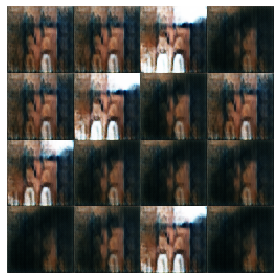

Epoch 5161
Epoch 5162
Epoch 5163
Epoch 5164
Epoch 5165
Epoch 5166
Epoch 5167
Epoch 5168
Epoch 5169
Epoch 5170
Epoch 5171
Epoch 5172
Epoch 5173
Epoch 5174
Epoch 5175
Epoch 5176
Epoch 5177
Epoch 5178
Epoch 5179
Epoch 5180
Displaying generated images


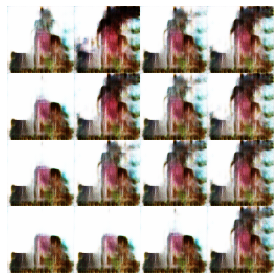

Epoch 5181
Epoch 5182
Epoch 5183
Epoch 5184
Epoch 5185
Epoch 5186
Epoch 5187
Epoch 5188
Epoch 5189
Epoch 5190
Epoch 5191
Epoch 5192
Epoch 5193
Epoch 5194
Epoch 5195
Epoch 5196
Epoch 5197
Epoch 5198
Epoch 5199
Epoch 5200
Displaying generated images


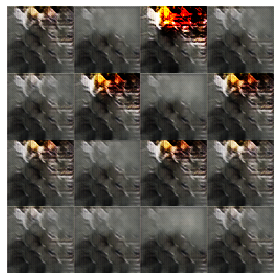

Epoch 5201
Epoch 5202
Epoch 5203
Epoch 5204
Epoch 5205
Epoch 5206
Epoch 5207
Epoch 5208
Epoch 5209
Epoch 5210
Epoch 5211
Epoch 5212
Epoch 5213
Epoch 5214
Epoch 5215
Epoch 5216
Epoch 5217
Epoch 5218
Epoch 5219
Epoch 5220
Displaying generated images


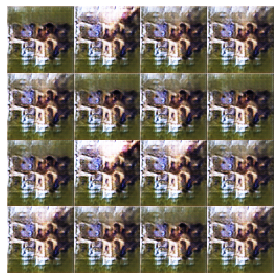

Epoch 5221
Epoch 5222
Epoch 5223
Epoch 5224
Epoch 5225
Epoch 5226
Epoch 5227
Epoch 5228
Epoch 5229
Epoch 5230
Epoch 5231
Epoch 5232
Epoch 5233
Epoch 5234
Epoch 5235
Epoch 5236
Epoch 5237
Epoch 5238
Epoch 5239
Epoch 5240
Displaying generated images


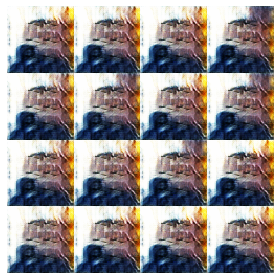

Epoch 5241
Epoch 5242
Epoch 5243
Epoch 5244
Epoch 5245
Epoch 5246
Epoch 5247
Epoch 5248
Epoch 5249
Epoch 5250
Epoch 5251
Epoch 5252
Epoch 5253
Epoch 5254
Epoch 5255
Epoch 5256
Epoch 5257
Epoch 5258
Epoch 5259
Epoch 5260
Displaying generated images


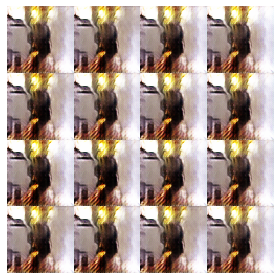

Epoch 5261
Epoch 5262
Epoch 5263
Epoch 5264
Epoch 5265
Epoch 5266
Epoch 5267
Epoch 5268
Epoch 5269
Epoch 5270
Epoch 5271
Epoch 5272
Epoch 5273
Epoch 5274
Epoch 5275
Epoch 5276
Epoch 5277
Epoch 5278
Epoch 5279
Epoch 5280
Displaying generated images


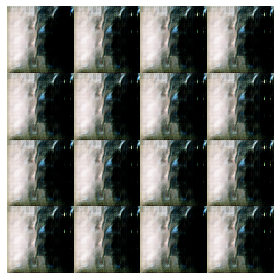

Epoch 5281
Epoch 5282
Epoch 5283
Epoch 5284
Epoch 5285
Epoch 5286
Epoch 5287
Epoch 5288
Epoch 5289
Epoch 5290
Epoch 5291
Epoch 5292
Epoch 5293
Epoch 5294
Epoch 5295
Epoch 5296
Epoch 5297
Epoch 5298
Epoch 5299
Epoch 5300
Displaying generated images


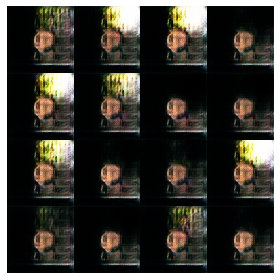

Epoch 5301
Epoch 5302
Epoch 5303
Epoch 5304
Epoch 5305
Epoch 5306
Epoch 5307
Epoch 5308
Epoch 5309
Epoch 5310
Epoch 5311
Epoch 5312
Epoch 5313
Epoch 5314
Epoch 5315
Epoch 5316
Epoch 5317
Epoch 5318
Epoch 5319
Epoch 5320
Displaying generated images


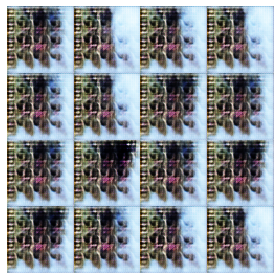

Epoch 5321
Epoch 5322
Epoch 5323
Epoch 5324
Epoch 5325
Epoch 5326
Epoch 5327
Epoch 5328
Epoch 5329
Epoch 5330
Epoch 5331
Epoch 5332
Epoch 5333
Epoch 5334
Epoch 5335
Epoch 5336
Epoch 5337
Epoch 5338
Epoch 5339
Epoch 5340
Displaying generated images


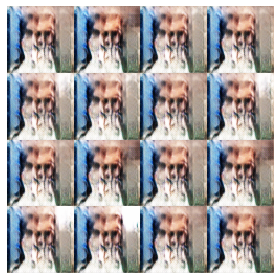

Epoch 5341
Epoch 5342
Epoch 5343
Epoch 5344
Epoch 5345
Epoch 5346
Epoch 5347
Epoch 5348
Epoch 5349
Epoch 5350
Epoch 5351
Epoch 5352
Epoch 5353
Epoch 5354
Epoch 5355
Epoch 5356
Epoch 5357
Epoch 5358
Epoch 5359
Epoch 5360
Displaying generated images


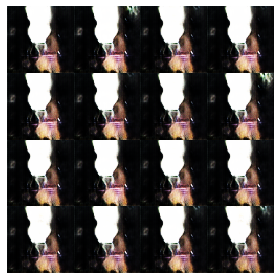

Epoch 5361
Epoch 5362
Epoch 5363
Epoch 5364
Epoch 5365
Epoch 5366
Epoch 5367
Epoch 5368
Epoch 5369
Epoch 5370
Epoch 5371
Epoch 5372
Epoch 5373
Epoch 5374
Epoch 5375
Epoch 5376
Epoch 5377
Epoch 5378
Epoch 5379
Epoch 5380
Displaying generated images


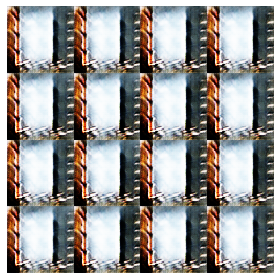

Epoch 5381
Epoch 5382
Epoch 5383
Epoch 5384
Epoch 5385
Epoch 5386
Epoch 5387
Epoch 5388
Epoch 5389
Epoch 5390
Epoch 5391
Epoch 5392
Epoch 5393
Epoch 5394
Epoch 5395
Epoch 5396
Epoch 5397
Epoch 5398
Epoch 5399
Epoch 5400
Displaying generated images


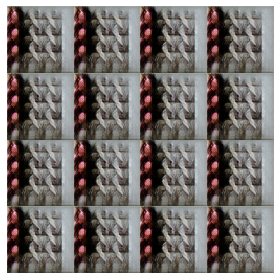

Epoch 5401
Epoch 5402
Epoch 5403
Epoch 5404
Epoch 5405
Epoch 5406
Epoch 5407
Epoch 5408
Epoch 5409
Epoch 5410
Epoch 5411
Epoch 5412
Epoch 5413
Epoch 5414
Epoch 5415
Epoch 5416
Epoch 5417
Epoch 5418
Epoch 5419
Epoch 5420
Displaying generated images


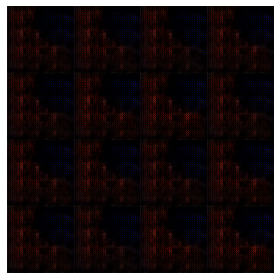

Epoch 5421
Epoch 5422
Epoch 5423
Epoch 5424
Epoch 5425
Epoch 5426
Epoch 5427
Epoch 5428
Epoch 5429
Epoch 5430
Epoch 5431
Epoch 5432
Epoch 5433
Epoch 5434
Epoch 5435
Epoch 5436
Epoch 5437
Epoch 5438
Epoch 5439
Epoch 5440
Displaying generated images


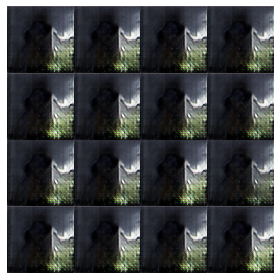

Epoch 5441
Epoch 5442
Epoch 5443
Epoch 5444
Epoch 5445
Epoch 5446
Epoch 5447
Epoch 5448
Epoch 5449
Epoch 5450
Epoch 5451
Epoch 5452
Epoch 5453
Epoch 5454
Epoch 5455
Epoch 5456
Epoch 5457
Epoch 5458
Epoch 5459
Epoch 5460
Displaying generated images


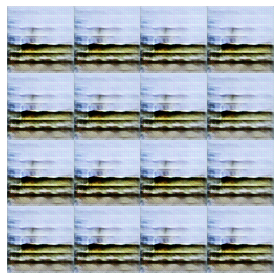

Epoch 5461
Epoch 5462
Epoch 5463
Epoch 5464
Epoch 5465
Epoch 5466
Epoch 5467
Epoch 5468
Epoch 5469
Epoch 5470
Epoch 5471
Epoch 5472
Epoch 5473
Epoch 5474
Epoch 5475
Epoch 5476
Epoch 5477
Epoch 5478
Epoch 5479
Epoch 5480
Displaying generated images


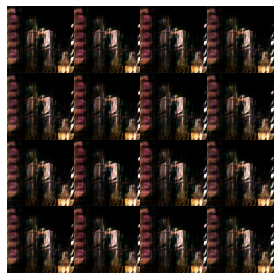

Epoch 5481
Epoch 5482
Epoch 5483
Epoch 5484
Epoch 5485
Epoch 5486
Epoch 5487
Epoch 5488
Epoch 5489
Epoch 5490
Epoch 5491
Epoch 5492
Epoch 5493
Epoch 5494
Epoch 5495
Epoch 5496
Epoch 5497
Epoch 5498
Epoch 5499
Epoch 5500
Displaying generated images


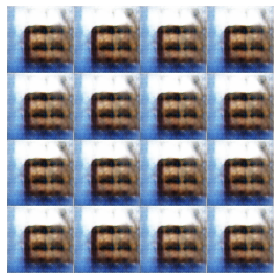

Epoch 5501
Epoch 5502
Epoch 5503
Epoch 5504
Epoch 5505
Epoch 5506
Epoch 5507
Epoch 5508
Epoch 5509
Epoch 5510
Epoch 5511
Epoch 5512
Epoch 5513
Epoch 5514
Epoch 5515
Epoch 5516
Epoch 5517
Epoch 5518
Epoch 5519
Epoch 5520
Displaying generated images


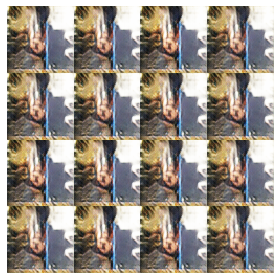

Epoch 5521
Epoch 5522
Epoch 5523
Epoch 5524
Epoch 5525
Epoch 5526
Epoch 5527
Epoch 5528
Epoch 5529
Epoch 5530
Epoch 5531
Epoch 5532
Epoch 5533
Epoch 5534
Epoch 5535
Epoch 5536
Epoch 5537
Epoch 5538
Epoch 5539
Epoch 5540
Displaying generated images


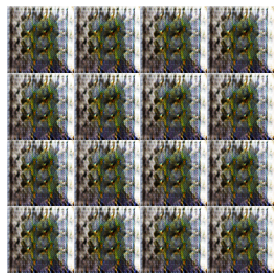

Epoch 5541
Epoch 5542
Epoch 5543
Epoch 5544
Epoch 5545
Epoch 5546
Epoch 5547
Epoch 5548
Epoch 5549
Epoch 5550
Epoch 5551
Epoch 5552
Epoch 5553
Epoch 5554
Epoch 5555
Epoch 5556
Epoch 5557
Epoch 5558
Epoch 5559
Epoch 5560
Displaying generated images


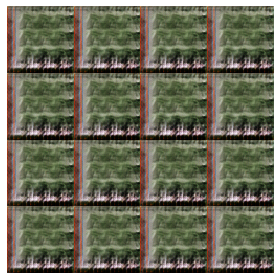

Epoch 5561
Epoch 5562
Epoch 5563
Epoch 5564
Epoch 5565
Epoch 5566
Epoch 5567
Epoch 5568
Epoch 5569
Epoch 5570
Epoch 5571
Epoch 5572
Epoch 5573
Epoch 5574
Epoch 5575
Epoch 5576
Epoch 5577
Epoch 5578
Epoch 5579
Epoch 5580
Displaying generated images


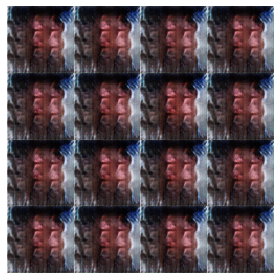

Epoch 5581
Epoch 5582
Epoch 5583
Epoch 5584
Epoch 5585
Epoch 5586
Epoch 5587
Epoch 5588
Epoch 5589
Epoch 5590
Epoch 5591
Epoch 5592
Epoch 5593
Epoch 5594
Epoch 5595
Epoch 5596
Epoch 5597
Epoch 5598
Epoch 5599
Epoch 5600
Displaying generated images


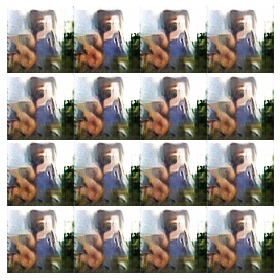

Epoch 5601
Epoch 5602
Epoch 5603
Epoch 5604
Epoch 5605
Epoch 5606
Epoch 5607
Epoch 5608
Epoch 5609
Epoch 5610
Epoch 5611
Epoch 5612
Epoch 5613
Epoch 5614
Epoch 5615
Epoch 5616
Epoch 5617
Epoch 5618
Epoch 5619
Epoch 5620
Displaying generated images


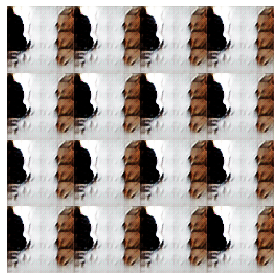

Epoch 5621
Epoch 5622
Epoch 5623
Epoch 5624
Epoch 5625
Epoch 5626
Epoch 5627
Epoch 5628
Epoch 5629
Epoch 5630
Epoch 5631
Epoch 5632
Epoch 5633
Epoch 5634
Epoch 5635
Epoch 5636
Epoch 5637
Epoch 5638
Epoch 5639
Epoch 5640
Displaying generated images


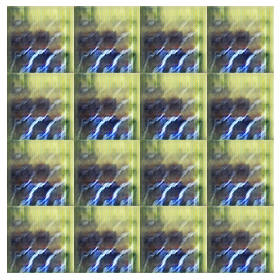

Epoch 5641
Epoch 5642
Epoch 5643
Epoch 5644
Epoch 5645
Epoch 5646
Epoch 5647
Epoch 5648
Epoch 5649
Epoch 5650
Epoch 5651
Epoch 5652
Epoch 5653
Epoch 5654
Epoch 5655
Epoch 5656
Epoch 5657
Epoch 5658
Epoch 5659
Epoch 5660
Displaying generated images


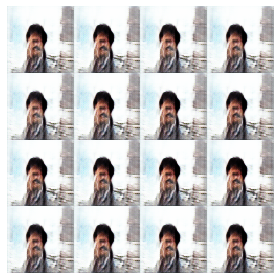

Epoch 5661
Epoch 5662
Epoch 5663
Epoch 5664
Epoch 5665
Epoch 5666
Epoch 5667
Epoch 5668
Epoch 5669
Epoch 5670
Epoch 5671
Epoch 5672
Epoch 5673
Epoch 5674
Epoch 5675
Epoch 5676
Epoch 5677
Epoch 5678
Epoch 5679
Epoch 5680
Displaying generated images


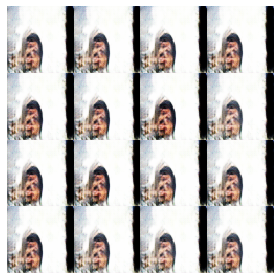

Epoch 5681
Epoch 5682
Epoch 5683
Epoch 5684
Epoch 5685
Epoch 5686
Epoch 5687
Epoch 5688
Epoch 5689
Epoch 5690
Epoch 5691
Epoch 5692
Epoch 5693
Epoch 5694
Epoch 5695
Epoch 5696
Epoch 5697
Epoch 5698
Epoch 5699
Epoch 5700
Displaying generated images


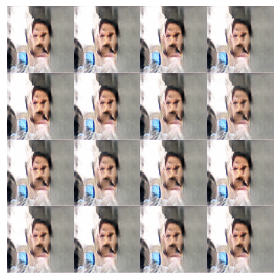

Epoch 5701
Epoch 5702
Epoch 5703
Epoch 5704
Epoch 5705
Epoch 5706
Epoch 5707
Epoch 5708
Epoch 5709
Epoch 5710
Epoch 5711
Epoch 5712
Epoch 5713
Epoch 5714
Epoch 5715
Epoch 5716
Epoch 5717
Epoch 5718
Epoch 5719
Epoch 5720
Displaying generated images


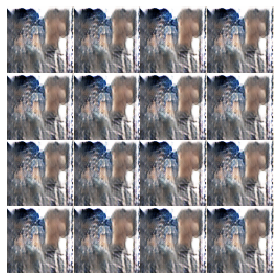

Epoch 5721
Epoch 5722
Epoch 5723
Epoch 5724
Epoch 5725
Epoch 5726
Epoch 5727
Epoch 5728
Epoch 5729
Epoch 5730
Epoch 5731
Epoch 5732
Epoch 5733
Epoch 5734
Epoch 5735
Epoch 5736
Epoch 5737
Epoch 5738
Epoch 5739
Epoch 5740
Displaying generated images


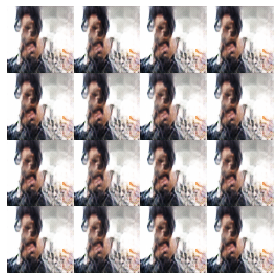

Epoch 5741
Epoch 5742
Epoch 5743
Epoch 5744
Epoch 5745
Epoch 5746
Epoch 5747
Epoch 5748
Epoch 5749
Epoch 5750
Epoch 5751
Epoch 5752
Epoch 5753
Epoch 5754
Epoch 5755
Epoch 5756
Epoch 5757
Epoch 5758
Epoch 5759
Epoch 5760
Displaying generated images


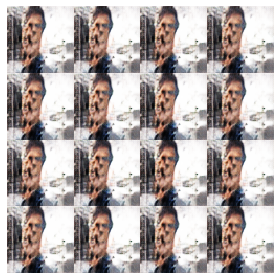

Epoch 5761
Epoch 5762
Epoch 5763
Epoch 5764
Epoch 5765
Epoch 5766
Epoch 5767
Epoch 5768
Epoch 5769
Epoch 5770
Epoch 5771
Epoch 5772
Epoch 5773
Epoch 5774
Epoch 5775
Epoch 5776
Epoch 5777
Epoch 5778
Epoch 5779
Epoch 5780
Displaying generated images


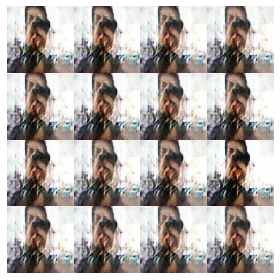

Epoch 5781
Epoch 5782
Epoch 5783
Epoch 5784
Epoch 5785
Epoch 5786
Epoch 5787
Epoch 5788
Epoch 5789
Epoch 5790
Epoch 5791
Epoch 5792
Epoch 5793
Epoch 5794
Epoch 5795
Epoch 5796
Epoch 5797
Epoch 5798
Epoch 5799
Epoch 5800
Displaying generated images


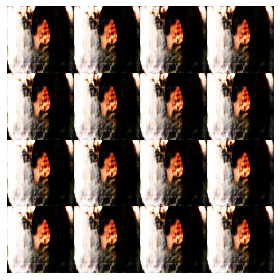

Epoch 5801
Epoch 5802
Epoch 5803
Epoch 5804
Epoch 5805
Epoch 5806
Epoch 5807
Epoch 5808
Epoch 5809
Epoch 5810
Epoch 5811
Epoch 5812
Epoch 5813
Epoch 5814
Epoch 5815
Epoch 5816
Epoch 5817
Epoch 5818
Epoch 5819
Epoch 5820
Displaying generated images


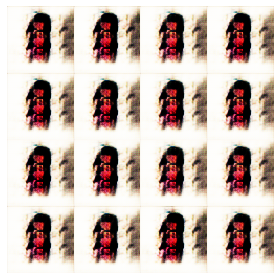

Epoch 5821
Epoch 5822
Epoch 5823
Epoch 5824
Epoch 5825
Epoch 5826
Epoch 5827
Epoch 5828
Epoch 5829
Epoch 5830
Epoch 5831
Epoch 5832
Epoch 5833
Epoch 5834
Epoch 5835
Epoch 5836
Epoch 5837
Epoch 5838
Epoch 5839
Epoch 5840
Displaying generated images


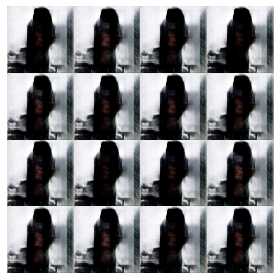

Epoch 5841
Epoch 5842
Epoch 5843
Epoch 5844
Epoch 5845
Epoch 5846
Epoch 5847
Epoch 5848
Epoch 5849
Epoch 5850
Epoch 5851
Epoch 5852
Epoch 5853
Epoch 5854
Epoch 5855
Epoch 5856
Epoch 5857
Epoch 5858
Epoch 5859
Epoch 5860
Displaying generated images


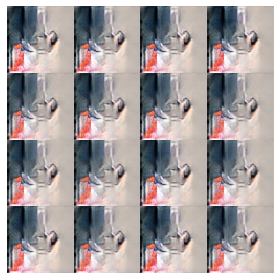

Epoch 5861
Epoch 5862
Epoch 5863
Epoch 5864
Epoch 5865
Epoch 5866
Epoch 5867
Epoch 5868
Epoch 5869
Epoch 5870
Epoch 5871
Epoch 5872
Epoch 5873
Epoch 5874
Epoch 5875
Epoch 5876
Epoch 5877
Epoch 5878
Epoch 5879
Epoch 5880
Displaying generated images


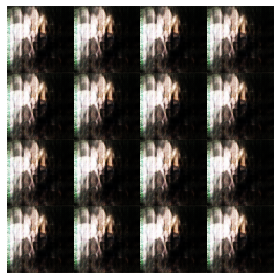

Epoch 5881
Epoch 5882
Epoch 5883
Epoch 5884
Epoch 5885
Epoch 5886
Epoch 5887
Epoch 5888
Epoch 5889
Epoch 5890
Epoch 5891
Epoch 5892
Epoch 5893
Epoch 5894
Epoch 5895
Epoch 5896
Epoch 5897
Epoch 5898
Epoch 5899
Epoch 5900
Displaying generated images


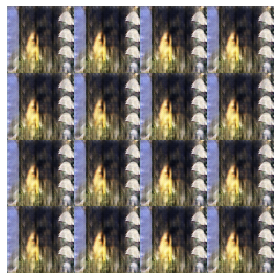

Epoch 5901
Epoch 5902
Epoch 5903
Epoch 5904
Epoch 5905
Epoch 5906
Epoch 5907
Epoch 5908
Epoch 5909
Epoch 5910
Epoch 5911
Epoch 5912
Epoch 5913
Epoch 5914
Epoch 5915
Epoch 5916
Epoch 5917
Epoch 5918
Epoch 5919
Epoch 5920


In [ ]:
epo=10000
for i in range(1,epo+1):
    print('Epoch %d' %i)
    for _ in range(batch):
        #Generation of random noise
        noise= gen_noise(batch,noise_shape)
        generated_images = g.predict(noise)
        # creating a batch of real images
        realbatch= sample_from_dataset(batch, image_shape, data_dir)
        #combining real and fake data
        x= np.concatenate([realbatch,generated_images])
        #labels for real and fake data for discriminator
        ydis=np.zeros(2*batch)
        ydis[:batch]=0.9
        #training the discriminator at first
        d.trainable=True
        d.train_on_batch(x,ydis)
        #fooling the generator by giving noised input as real data
        ygen= np.ones(batch)
        #Now freezing the discriminator weights
        d.trainable=False
        #now we train the gan model
        gan.train_on_batch(noise, ygen)
    if i==1 or i%20==0:
        generate_images(g,"generated_images/")
        g.save('model_weights/'+'epoch'+ str(i)+"_GENERATOR_weights_and_arch.hdf5")
        d.save('model_weights/'+'epoch'+ str(i)+"_DISCRIMINATOR_weights_and_arch.hdf5")